# PCA y T-SNE para visualización de dataset de alta dimensionalidad

La base de datos **MNIST** (Modified National Institute of Standards and Technology database) es una gran base de datos de dígitos escritos a mano que se usa comúnmente para entrenar varios sistemas de procesamiento de imágenes. Fue creado "mezclando nuevamente" las muestras de los conjuntos de datos originales de NIST. Los creadores sintieron que, dado que el conjunto de datos de capacitación del NIST fue tomado de los empleados de la Oficina del Censo de los Estados Unidos, mientras que el conjunto de datos de prueba fue tomado de los estudiantes de secundaria estadounidenses, no era adecuado para los experimentos de aprendizaje automático. Además, las imágenes en blanco y negro de NIST se normalizaron para caber en un tamaño de 28x28 píxeles.

The MNIST database contains 60,000 training images and 10,000 testing images.[6] Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset.

Empezemos importando las librerías que vamos a usar.

In [1]:
from __future__ import print_function

import time
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Solo por el dataset
import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

Ahora que tenemos ya todas las librerías, vamos a importar la base de datos MNIST y *printemos* el tamaño de los datasets. 

In [2]:
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x = np.reshape(x,(60000,784))/255.0

print(x.shape, y.shape)

(60000, 784) (60000,)


Para hacer la vida más fácil, vamos a crear un DataFrame en Pandas, nos facilitará las cosas luego. Esto no es del todo necesario.

In [3]:
feat_cols = [ 'pixel'+str(i) for i in range(x.shape[1]) ]
df = pd.DataFrame(x,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
x, y = None, None
print('Tamaño del dataframe: {}'.format(df.shape))

Tamaño del dataframe: (60000, 786)


Vamos a simplificar un poco el problema, ya que 60000 caracteres son muchos y puede ser que el ordenador le cueste un poco. Lo que vamos a hacer es, y dado que el dataset esta ordenador por valores de los caracteres, aleatoriamente cojer un subset de estos creando un vector de valores aleatorios que usaremos como índices.

In [4]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

Vamos a visualizar primero que es lo que tenemos en el dataset. Para eso vamos a *plotear* los dígitos.

<Figure size 432x288 with 0 Axes>

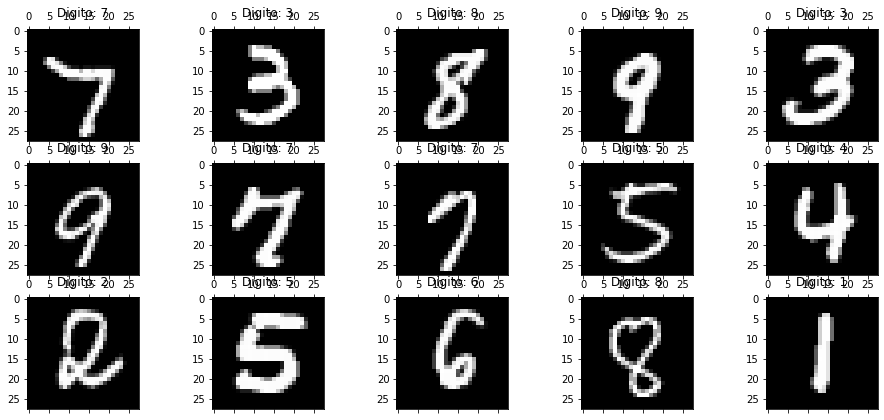

In [5]:
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digito: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

## PCA

Como sabemos, el dataset contiene estas imagenes que son 28x28 píxeles, correspondiendo a un espacio de 784 dimensiones, esto es mucho. Vamos a reducir el espacio de entreno, y mas sabiendo que solo podemos ver 3 dimensiones (Realmente 4, pero sin vídeo es dificil). Empezaremos pues con el PCA.

In [6]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explicación de la varianza de los primero componentes: {}'.format(pca.explained_variance_ratio_))

Explicación de la varianza de los primero componentes: [0.09704664 0.07095924 0.06169089]


Com sabeis viendo el resultado de los primeros 3 autovalores, eigenvalues, capturamos un poco mas del 22% de la *información* o energía. Vamos a ver los primeros de 2D que hemos extraido de la PCA a ver si vemos o no diferencia entre los dígitos. ¿Qué creeis?

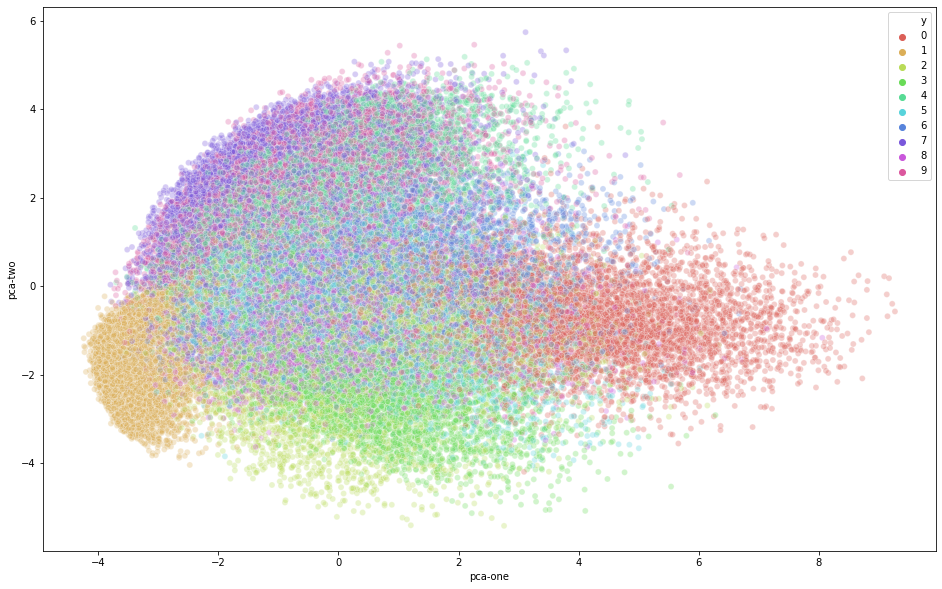

In [7]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

Podemos ver que hay algunos dígitos que si estan separados, el 1 del 0 claramente, pero el 3 del 7 pero hay mucho solapameiento entre ellos. No hemos capturado la suficiente varianza como para poder "separar estos datos". Vamos a ver ahora con 3D a ver si mejora.

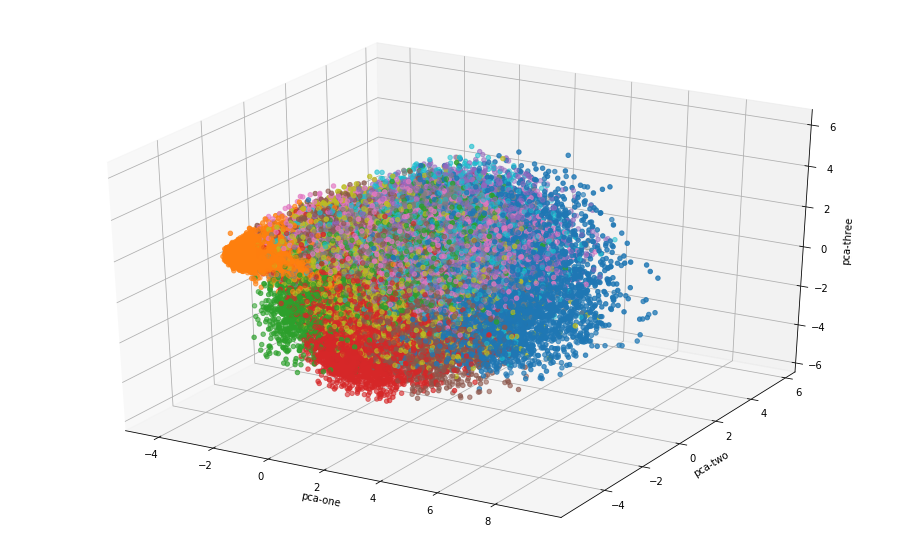

In [8]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

Hemos pasado de capturar el 16% de la varianza a pasar al 23% y claramente ha mejorado, todo y así no es suficiente para separar, o visualizar los clusters generados por los dígitos como esperariamos... Vamos a ver si hay algo mejor.

## T-SNE

T-Distributed Stochastic Neighbor Embedding. Es otra técnica para la reducción de la dimensionalidad y es particularmente adecuada para la visualización de conjuntos de datos de altas dimensiónes. Contrariamente a PCA, no es una técnica algebraica sino probablística. 

Esta técnica analiza los datos originales que se introducen en el algoritmo y analiza cómo representar mejor estos datos utilizando menos dimensiones al hacer coincidir ambas distribuciones. La forma en que lo hace es computacionalmente intensiva y, por lo tanto, existen algunas limitaciones (serias) para el uso de esta técnica. Por ejemplo, una de las recomendaciones es que, en caso de datos dimensionales muy altos, normalmente más de 50, es posible que deba aplicar otra técnica de reducción de dimensionalidad antes de usar t-SNE, como ahora el PCA.

Para minimizar el tiempo de computo, vamos a limintar el numero de dígitos de los 60000 a los 10000. Primero, y para poder comparar saquemos otra vez el PCA de este subset tal y como hemos hecho antes, los valores seran muy similares.

In [9]:
time_start = time.time()
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explicación de la varianza de los primero componentes: {}'.format(pca.explained_variance_ratio_))
print('PCA Acabado! Tiempo de computo: {} segundos'.format(time.time()-time_start))

Explicación de la varianza de los primero componentes: [0.09614987 0.07138535 0.06078229]
PCA Acabado! Tiempo de computo: 0.43900227546691895 segundos


Vamos ahora a pasar el T-SNE sobre el dataset. Añadimos el tiempo para que veais la diferencia grande que hay entre los algoritmos.

In [10]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE acabado! tiempo de computo: {} segundos'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.767s...
[t-SNE] Computed neighbors for 10000 samples in 103.712s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.136576
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.144318
[t-SNE] KL divergence after 300 iterations: 2.896781
t-SNE acabado! tiempo d

Vamos ahora a visualizar que es lo que ha hecho el T-SNE visualizando primero 2D:

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Como podeis comprovar el resultado es mucho mejor que el que teniamos con PCA, las clases están mucho más separadas. Si ploteamos las dos soluciones lado a lado:

In [ ]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

Claramente t-SNE hace un mucho mejor trabajo en capturar la *esencia* de la información.

## Tarea

\begin{itemize}
\item Como hemos comentado antes, y con todo lo que aprendisteis en el otro módulo, aplicar el PCA *óptimo* y hacer entonces el t-SNE y comprobar los resultados.
\item Hacer lo mismo con algún dataset que háyais trabajo estas últimas semanas.
\end{itemize}